In [ ]:
import pickle
from transformers import AutoTokenizer
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
post_samples_path = 'model_outputs/ContextualAI_archangel_sft_pythia2-8b_euclaise_writingprompts_validation_samples_100.pkl'
base_samples_path = 'model_outputs/EleutherAI_pythia-2.8b_euclaise_writingprompts_validation_samples_100.pkl'

with open(post_samples_path, 'rb') as f:
    post_samples = pickle.load(f)
with open(base_samples_path, 'rb') as f:
    base_samples = pickle.load(f)

tokenizer = AutoTokenizer.from_pretrained('EleutherAI/pythia-2.8b')

In [ ]:
def plot_top_k_distribution_comparison(sample_a, sample_b, tokenizer, token_pos, k=10, sample_a_name='Sample A', sample_b_name='Sample B'):
    """
    Compare the top k token prob distribution of two samples.
    Note: The distribution plot might have [k, 2k] tokens, 
          these are combined top-k logits from both samples.
    """
    probs_a = sample_a['generated_logits'].softmax(dim=-1)[token_pos].unsqueeze(0)
    probs_b = sample_b['generated_logits'].softmax(dim=-1)[token_pos].unsqueeze(0)

    top_k_a = probs_a.topk(k, dim=-1).indices
    top_k_b = probs_b.topk(k, dim=-1).indices

    # combine to get all the token ids (unique)
    combined_top_k = torch.unique(torch.cat([top_k_a, top_k_b], dim=-1)).tolist()
    combined_probs_a = probs_a[0, combined_top_k].numpy()
    combined_probs_b = probs_b[0, combined_top_k].numpy()
    
    # Get token strings for visualization
    token_labels = [repr(tokenizer.decode(token_id)) for token_id in combined_top_k]
    
    # Sort by average probability to make the plot more readable
    avg_probs = (combined_probs_a + combined_probs_b) / 2
    sort_indices = np.argsort(avg_probs)[::-1]  # descending order
    
    combined_probs_a = combined_probs_a[sort_indices]
    combined_probs_b = combined_probs_b[sort_indices]
    token_labels = [token_labels[i] for i in sort_indices]
    combined_top_k = [combined_top_k[i] for i in sort_indices]
    
    # Plotting
    plt.figure(figsize=(16, 6))
    x = np.arange(len(combined_top_k))
    width = 0.35
    
    plt.bar(x - width/2, combined_probs_a, width, label=sample_a_name)
    plt.bar(x + width/2, combined_probs_b, width, label=sample_b_name)
    plt.grid(True, axis='y')
    plt.ylabel('Probability')
    plt.xlabel('Tokens')
    plt.title(f'Top-{k} token probability distribution comparison')
    plt.xticks(x, token_labels, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    
    # print prefix and prob table
    story_prefix_ids = tokenizer(sample_a["story"]).input_ids[:token_pos]
    story_prefix = tokenizer.decode(story_prefix_ids)
    print(f"Prefix:\n{sample_b["prompt"]} {story_prefix}\n\n")
    print(f"{'Token ID':<10} {'Token':<15} {sample_a_name:<15} {sample_b_name:<15} Diff")
    print('-' * 65)
    for i, token_id in enumerate(combined_top_k):
        prob_diff = combined_probs_a[i] - combined_probs_b[i]
        print(f"{token_id:<10} {token_labels[i]:<15} {combined_probs_a[i]:<15.6f} {combined_probs_b[i]:<15.6f} {prob_diff:<15.6f}")
    
    plt.show()

Prefix:
Write a creative story based on the following prompt:
[ WP ] Today is the last day the ocean will have waves .

 21 June 2148 
 
 
 Today was the last day of the last summer. The southern hemisphere had their final summer and now it was our turn. I watched from the
Token ID   Token           SFT Model       Base Model      Diff
-----------------------------------------------------------------
11600      ' beach'        0.106884        0.087847        0.019037       
16838      ' shore'        0.080505        0.063901        0.016604       
3497       ' window'       0.070947        0.073448        -0.002500      
36009      ' balcony'      0.057313        0.060569        -0.003256      
1755       ' top'          0.057103        0.058901        -0.001797      
5024       ' edge'         0.025398        0.028746        -0.003348      
12927      ' ocean'        0.027455        0.018145        0.009310       
12595      ' deck'         0.026543        0.018501        0.008042    

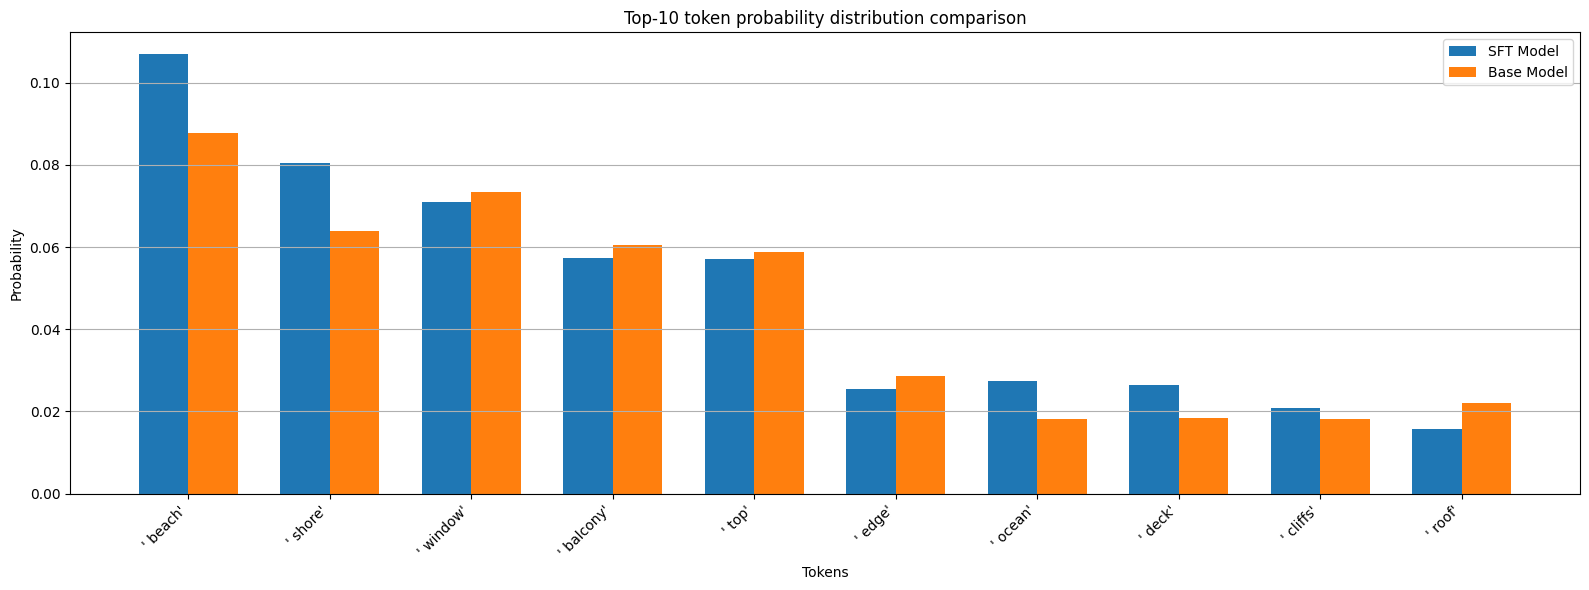

In [ ]:
# CHANGE THE TWO VARIABLES BELOW TO SELECT THE SAMPLE AND TOKEN POSITION
sample_idx = 0  # Choose a sample index
token_pos = 34  # Choose a token position to analyze

plot_top_k_distribution_comparison(
    post_samples[sample_idx], 
    base_samples[sample_idx], 
    tokenizer,
    token_pos=token_pos,
    k=10,
    sample_a_name='SFT Model',
    sample_b_name='Base Model'
)